In [3]:
pip install -r requirements1.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
import argparse
import os
from tensorflow.keras.applications import InceptionV3


In [5]:
args = {}
args["dataset"] = r"D:\SDP\INCEP_v3\dataset"  # replace with your actual dataset path
args["plot"] = r"D:\SDP\INCEP_v3\plot.png"  # replace with your desired plot path
args["model"] = r"D:\SDP\INCEP_v3\IncepV3.model"  # replace with your desired mIncepV3.modelth


In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

IMG_SIZE = 224
CHANNELS = 3
N_LABELS=2

[INFO] loading images...


In [7]:
# loop over the image paths
from PIL import Image
for imagePath in imagePaths:
	# extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  image = Image.open(imagePath)
  if image.mode == 'P':
    image = image.convert('RGBA') 
	# load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(IMG_SIZE, IMG_SIZE))
  image = img_to_array(image)
  image = image/255
#image = preprocess_input(image)

	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)


C:\Users\utkar\anaconda3\envs\incepv3\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)


In [9]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
feature_extractor_layer = InceptionV3(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 2)                 2050      
Total params: 74,234,658
Trainable params: 52,431,874
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
feature_extractor_layer.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [14]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 20
BS = 256

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"])

import time
start = time.time()
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	epochs=EPOCHS)
print('\nTraining took {}'.format((time.time()-start)))

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

print("[INFO] saving mask detector model...")
#model.save(args["model"], save_format="h5")

Epoch 1/20
12/12 [==============================] - 141s 11s/step - loss: 0.3596 - accuracy: 0.8694 - val_loss: 0.0596 - val_accuracy: 0.9841
Epoch 2/20
12/12 [==============================] - 135s 11s/step - loss: 0.1043 - accuracy: 0.9649 - val_loss: 0.0340 - val_accuracy: 0.9902
Epoch 3/20
12/12 [==============================] - 137s 12s/step - loss: 0.0700 - accuracy: 0.9794 - val_loss: 0.0290 - val_accuracy: 0.9963
Epoch 4/20
12/12 [==============================] - 135s 11s/step - loss: 0.0629 - accuracy: 0.9794 - val_loss: 0.0250 - val_accuracy: 0.9976
Epoch 5/20
12/12 [==============================] - 135s 11s/step - loss: 0.0596 - accuracy: 0.9798 - val_loss: 0.0224 - val_accuracy: 0.9976
Epoch 6/20
12/12 [==============================] - 135s 11s/step - loss: 0.0434 - accuracy: 0.9851 - val_loss: 0.0205 - val_accuracy: 0.9976
Epoch 7/20
12/12 [==============================] - 137s 12s/step - loss: 0.0505 - accuracy: 0.9867 - val_loss: 0.0192 - val_accuracy: 0.9976
Epoch 

In [15]:
 model.save(args["model"], save_format="h5")

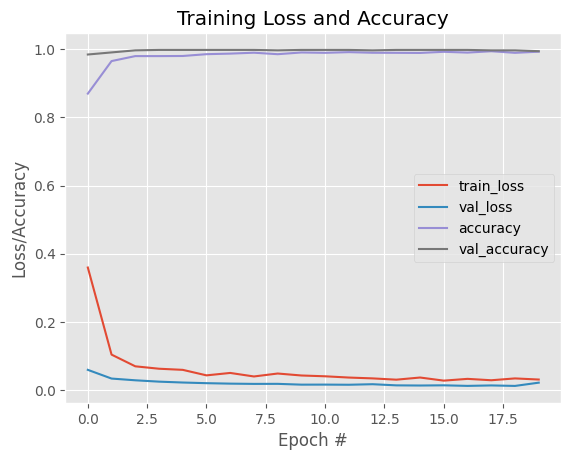

In [16]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig(args["plot"])


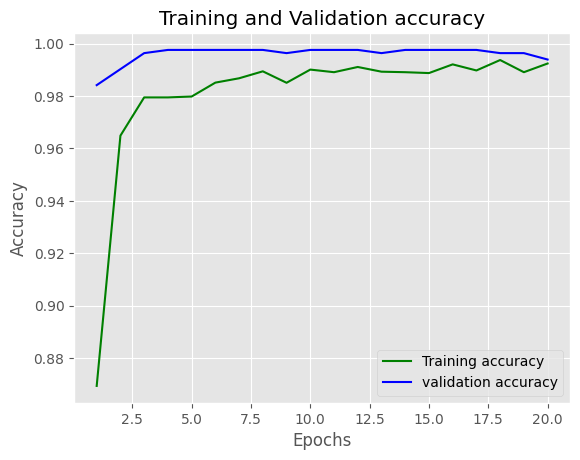

In [18]:
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,21)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()    
    plt.savefig(r"D:\SDP\Chandrika_FMD\Tra_Val_acc.png")
    plt.show()

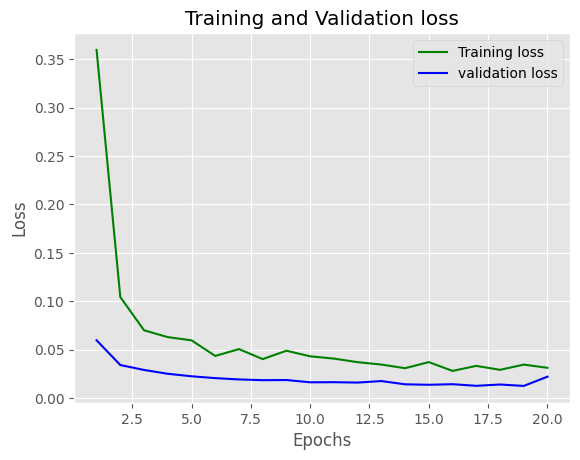

In [20]:
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(r"D:\SDP\INCEP_v3\Tra_Val_loss.png")
    plt.show()